# Bitcoin and Gold: A fool's debate?

## Introduction
We are going to be looking at historic Bitcoin, Gold, and S&P 500 data, pretty much as far back as we can source them for (given the market has sufficient liquidity to warrant an analysis), and see whether we can draw any conclusions from the data.

## Data
We have sourced data as follows:
- Gold: daily price data for one troy ounce of Gold in USD was sourced from the World Gold Council (https://www.gold.org/goldhub/data/gold-prices) for the period ranging from 29 December 1978 to 3 February 2025.
- Bitcoin: daily prices where sourced from Coinbase (a large, long-standing, centralized spot exchange), via their API - one of the few ones that provide free data via their API - over the period 20 July 2015 (the first date for which Coinbase has a price, that we could retrieve), to 3 February 2025.
- S&P 500: daily prices where sourced from za.investing.com from 1980 onwards, which aligned with the data from a research file on Kaggle, and the Kaggle data from 1926 to 1980.

We believe that this is a sufficiently large dataset from which we can draw meaningful results.

We have included the tools to download the bitcoin price data from coinbase in the utils directory, should you wish to pull it yourself.

In [31]:
# Should the results (plots) be saved?
save_results = False

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load gold prices and drop all columns except for price
gold_data = pd.read_csv('./data/gold_data.csv', dtype={'USD': 'float64'}, parse_dates=['Date'], date_format='%d-%b-%Y')
gold_data = gold_data[['Date', 'USD']]
gold_data.rename(columns={'USD': 'XAUUSD'}, inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

# load bitcoin prices and drop all columns except for time, closing price, and volume
btc_data = pd.read_csv('./data/btc_coinbase_prices.csv', dtype={'Close': 'float64', 'Volume': 'float64'}, parse_dates=['Time'],date_format='%d-%b-%Y')
btc_data = btc_data[['Time', 'Close', 'Volume']]
btc_data.rename(columns={'Time': 'Date', 'Close': 'BTCUSD'}, inplace=True)
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# load bitcoin prices and drop all columns except for time, closing price, and volume
spx_data = pd.read_csv('./data/spx_data.csv', dtype={'Close': 'float64'}, parse_dates=['Date'], date_format='%d-%b-%Y')
spx_data = spx_data[['Date', 'Close']]
spx_data.rename(columns={'Close': 'SPX'}, inplace=True)
spx_data['Date'] = pd.to_datetime(spx_data['Date'])

## Analysis

We calculate daily log returns, which we are going to use for calculating realised volatilities on a given day as follows:
1. Annual realized volatility:
    - For Gold, use the last 252 business days of log returns (which corresponds to roughly a year), and calculate the standard deviation of these (which gives us a 1-day volatility). We then annualize this volatility by multiplying by the square root of 252.
    - For BTC, given that the market trades 365 days a year, we use the same method but use 365 days of log returns, and annualize the volatility by multiplying by sqrt(365).
2. Monthly realized volatility:
    - For Gold, we use the standard deviation of 21 business days of log returns (corresponding to a month) multiplied by sqrt(252).
    - For Bitcoin, we use the standard deviation of 30 days of log returns (corresponding to a month) multiplied by sqrt(30).

Volatility gives us an indication of the dispersion of the returns of an asset, i.e., how much they move around the mean. A higher volatility means that prices move around more, and that there is more uncertainty.

For each day in our analysis window, we calculate the realized volatility using the above formulae, yielding a timeseries of so-called rolling volatilities, showing how volatility changes over time.

In [32]:
# Compute gold log returns and vols
gold_data['Daily_Log_Return'] = np.log(gold_data['XAUUSD'] / gold_data['XAUUSD'].shift(1))
gold_data['Annual_RV'] = gold_data['Daily_Log_Return'].rolling(252).std() * np.sqrt(252)
gold_data['Monthly_RV'] = gold_data['Daily_Log_Return'].rolling(21).std() * np.sqrt(252)
# Resample gold_data weekly - this will be used for display purposes, not further analysis
gold_data_weekly = gold_data.set_index('Date')
gold_data_weekly = gold_data_weekly.resample('W').mean()
gold_data_weekly = gold_data_weekly.reset_index()

# Compute btc log returns and vols
btc_data['Daily_Log_Return'] = np.log(btc_data['BTCUSD'] / btc_data['BTCUSD'].shift(1))
btc_data['Annual_RV'] = btc_data['Daily_Log_Return'].rolling(365).std() * np.sqrt(365)
btc_data['Monthly_RV'] = btc_data['Daily_Log_Return'].rolling(30).std() * np.sqrt(365)

# Compute spx log returns and vols
spx_data['Daily_Log_Return'] = np.log(spx_data['SPX'] / spx_data['SPX'].shift(1))
spx_data['Annual_RV'] = spx_data['Daily_Log_Return'].rolling(252).std() * np.sqrt(252)
spx_data['Monthly_RV'] = spx_data['Daily_Log_Return'].rolling(21).std() * np.sqrt(252)
# Resample spx_data weekly - this will be used for display purposes, not further analysis
spx_data_weekly = spx_data.set_index('Date')
spx_data_weekly = spx_data_weekly.resample('W').mean()
spx_data_weekly = spx_data_weekly.reset_index()


Let's plot the timeseries of prices of gold and bitcoin, and their respective realized volatilites.

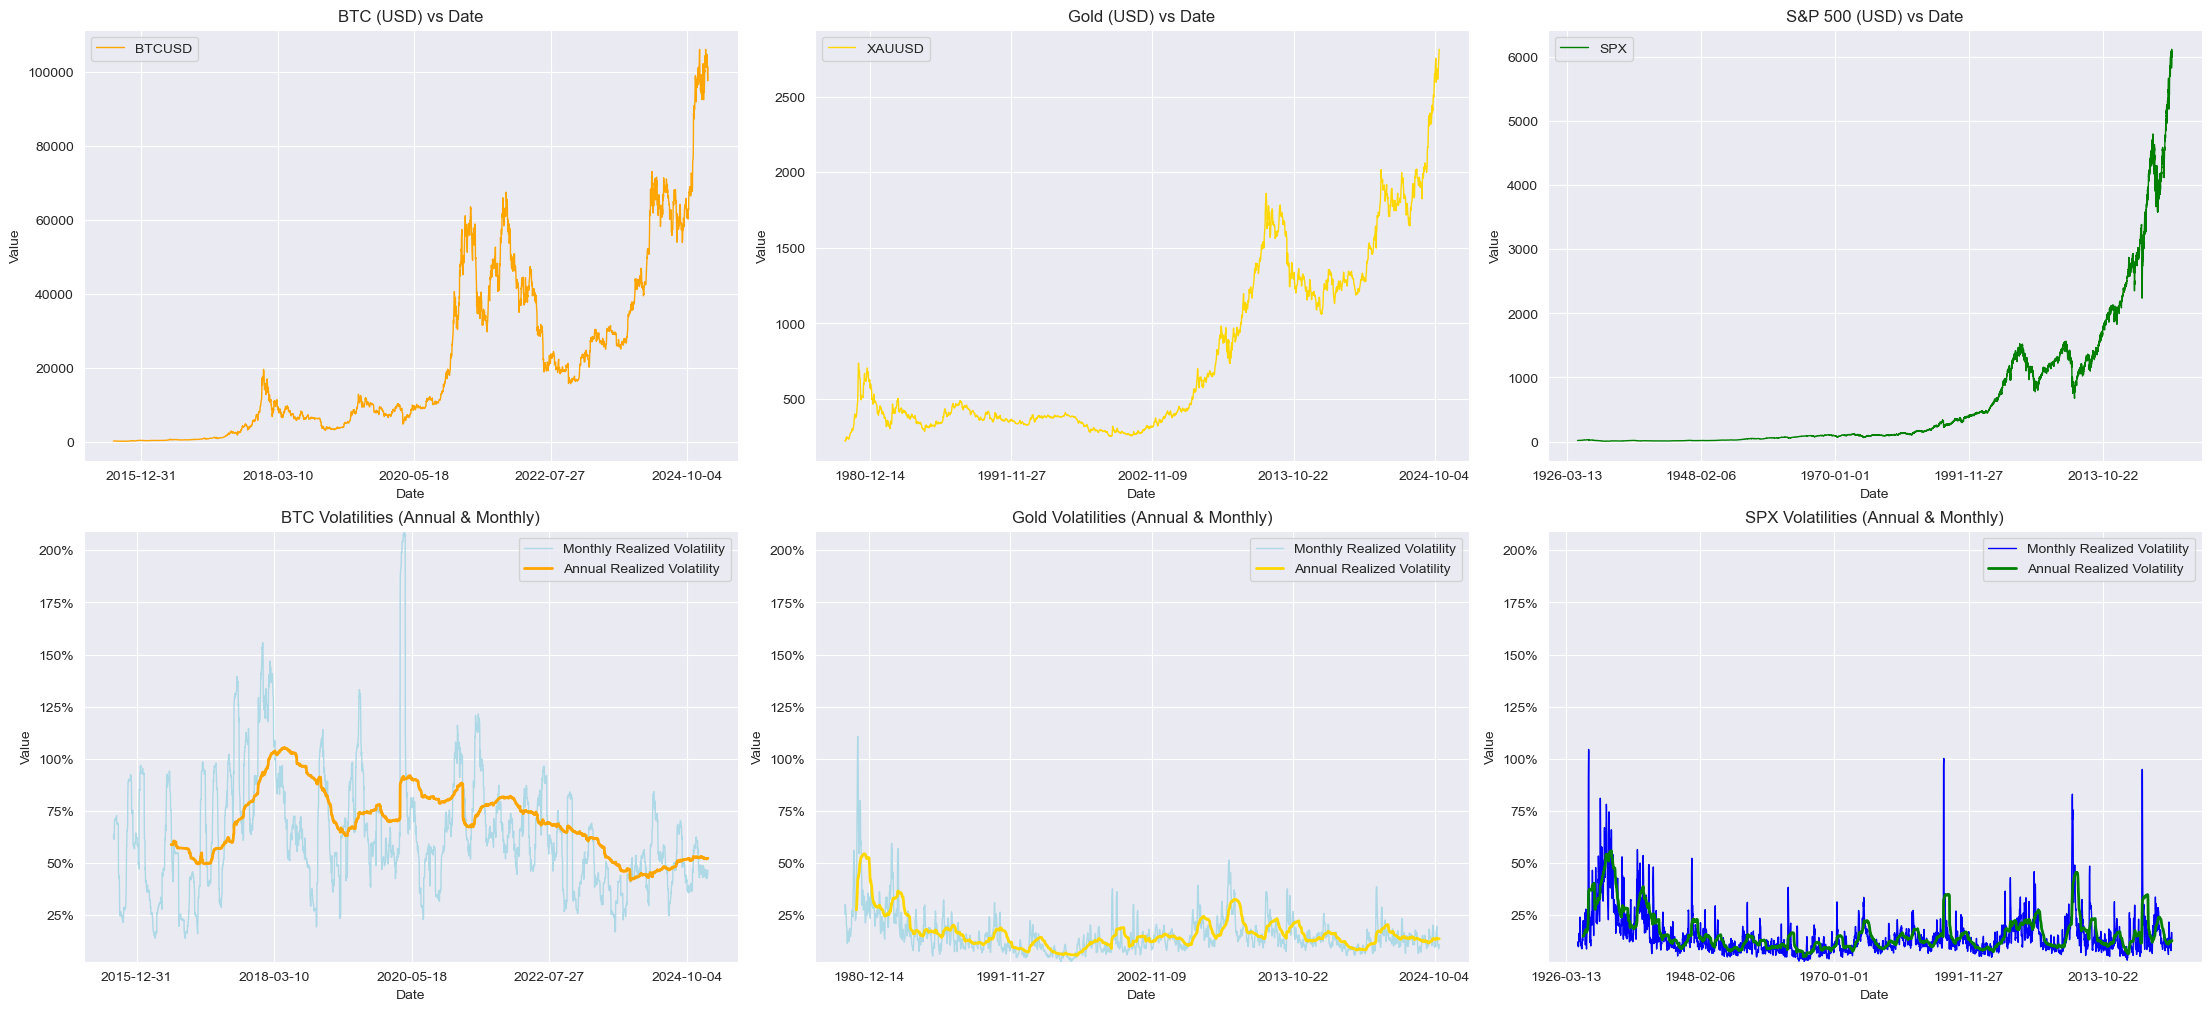

In [33]:
# Create a 2x3 grid of plots
fig, axes = plt.subplots(2, 3, figsize=(22, 10), constrained_layout=True)  # Adjusted columns to fit SPX plots

# Plot BTCUSD, XAUUSD, and SPX against Date in the first row
sns.lineplot(ax=axes[0, 0], data=btc_data, x='Date', y='BTCUSD', label='BTCUSD', color='orange', linewidth=1)
sns.lineplot(ax=axes[0, 1], data=gold_data_weekly, x='Date', y='XAUUSD', label='XAUUSD', color='gold', linewidth=1)
sns.lineplot(ax=axes[0, 2], data=spx_data, x='Date', y='SPX', label='SPX', color='green', linewidth=1)

# Titles for the first row
axes[0, 0].set_title('BTC (USD) vs Date')
axes[0, 1].set_title('Gold (USD) vs Date')
axes[0, 2].set_title('S&P 500 (USD) vs Date')

# Plot Annual_RV and Monthly_RV for btc_data in the second row, first column
sns.lineplot(ax=axes[1, 0], data=btc_data, x='Date', y='Monthly_RV', label='Monthly Realized Volatility', color='lightblue', linewidth=1)
sns.lineplot(ax=axes[1, 0], data=btc_data, x='Date', y='Annual_RV', label='Annual Realized Volatility', color='orange', linewidth=2)
axes[1, 0].set_title('BTC Volatilities (Annual & Monthly)')

# Plot Annual_RV and Monthly_RV for gold_data in the second row, second column
sns.lineplot(ax=axes[1, 1], data=gold_data_weekly, x='Date', y='Monthly_RV', label='Monthly Realized Volatility', color='lightblue', linewidth=1)
sns.lineplot(ax=axes[1, 1], data=gold_data_weekly, x='Date', y='Annual_RV', label='Annual Realized Volatility', color='gold', linewidth=2)
axes[1, 1].set_title('Gold Volatilities (Annual & Monthly)')

# Plot Annual_RV and Monthly_RV for spx_data in the second row, third column
sns.lineplot(ax=axes[1, 2], data=spx_data_weekly, x='Date', y='Monthly_RV', label='Monthly Realized Volatility', color='blue', linewidth=1)
sns.lineplot(ax=axes[1, 2], data=spx_data_weekly, x='Date', y='Annual_RV', label='Annual Realized Volatility', color='green', linewidth=2)
axes[1, 2].set_title('SPX Volatilities (Annual & Monthly)')

# Set the same y-axis limits for the second row's plots
min_y = min(
    btc_data[['Annual_RV', 'Monthly_RV']].min().min(),
    gold_data_weekly[['Annual_RV', 'Monthly_RV']].min().min(),
    spx_data_weekly[['Annual_RV', 'Monthly_RV']].min().min()
)
max_y = max(
    btc_data[['Annual_RV', 'Monthly_RV']].max().max(),
    gold_data_weekly[['Annual_RV', 'Monthly_RV']].max().max(),
    spx_data_weekly[['Annual_RV', 'Monthly_RV']].max().max()
)
axes[1, 0].set_ylim(min_y, max_y)
axes[1, 1].set_ylim(min_y, max_y)
axes[1, 2].set_ylim(min_y, max_y)

# Add legends, improve axis labels and make x-axis sparse
for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Reduce the number of x-axis ticks for sparsity

# Show the second row's y-axis as percentages
for ax in axes[1, :]:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

# Show and save plot
if save_results:
    plt.savefig('./results/asset_price_and_vol_grid.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

From the above we can see the following:
- Bitcoin is, on average, more volatile than Gold and the S&P500.
- Looking at the period spanning across 1978 to 1980, at some point Gold recorded a monthly volatility in excess of 100%, higher than what we see in our entire time series of the S&P500. Similarly, it had an annualized volatility in excess of 50%. These numbers are in line with what we have been seeing in Bitcoin over the last year.
- It isn't immediately clear whether the S&P 500 is more volatile than Gold.

There is however, good volatility and bad volatility.

_Good Volatility:_
- Opportunity for Profit: It can create opportunities for traders and investors to buy low and sell high. Higher volatility can lead to greater price movements, which means more potential for profit.
- Market Efficiency: Good volatility reflects healthy market activity with active buying and selling. It can indicate that the market is responding to new information and adjusting prices accordingly.
- Enterprises Growth: In some contexts, volatility can signal a dynamic environment where companies that innovate or adapt quickly might thrive.

_Bad Volatility:_
- Market Instability: This type of volatility often results from panic selling or other irrational behaviors, leading to unpredictable price swings that can destabilize a market.
- Risk and Uncertainty: Bad volatility is typically associated with economic distress, geopolitical issues, or poor company performance, making it risky for investors and potentially leading to losses.
- Investor Anxiety: It can deter long-term investors who prefer stable environments. High uncertainty can lead to decreased market confidence.

So let's gauge volatility in the context of the above. To aid us in this, we are going to look at Drawdown Charts. A Drawdown Chart shows the decline from the prior high to the current price. To calculate it we calculate a running maximum for each date, i.e., the maximum price recorded up to a given date. We then calculate the percentage change from the current price to the runnning maximum.

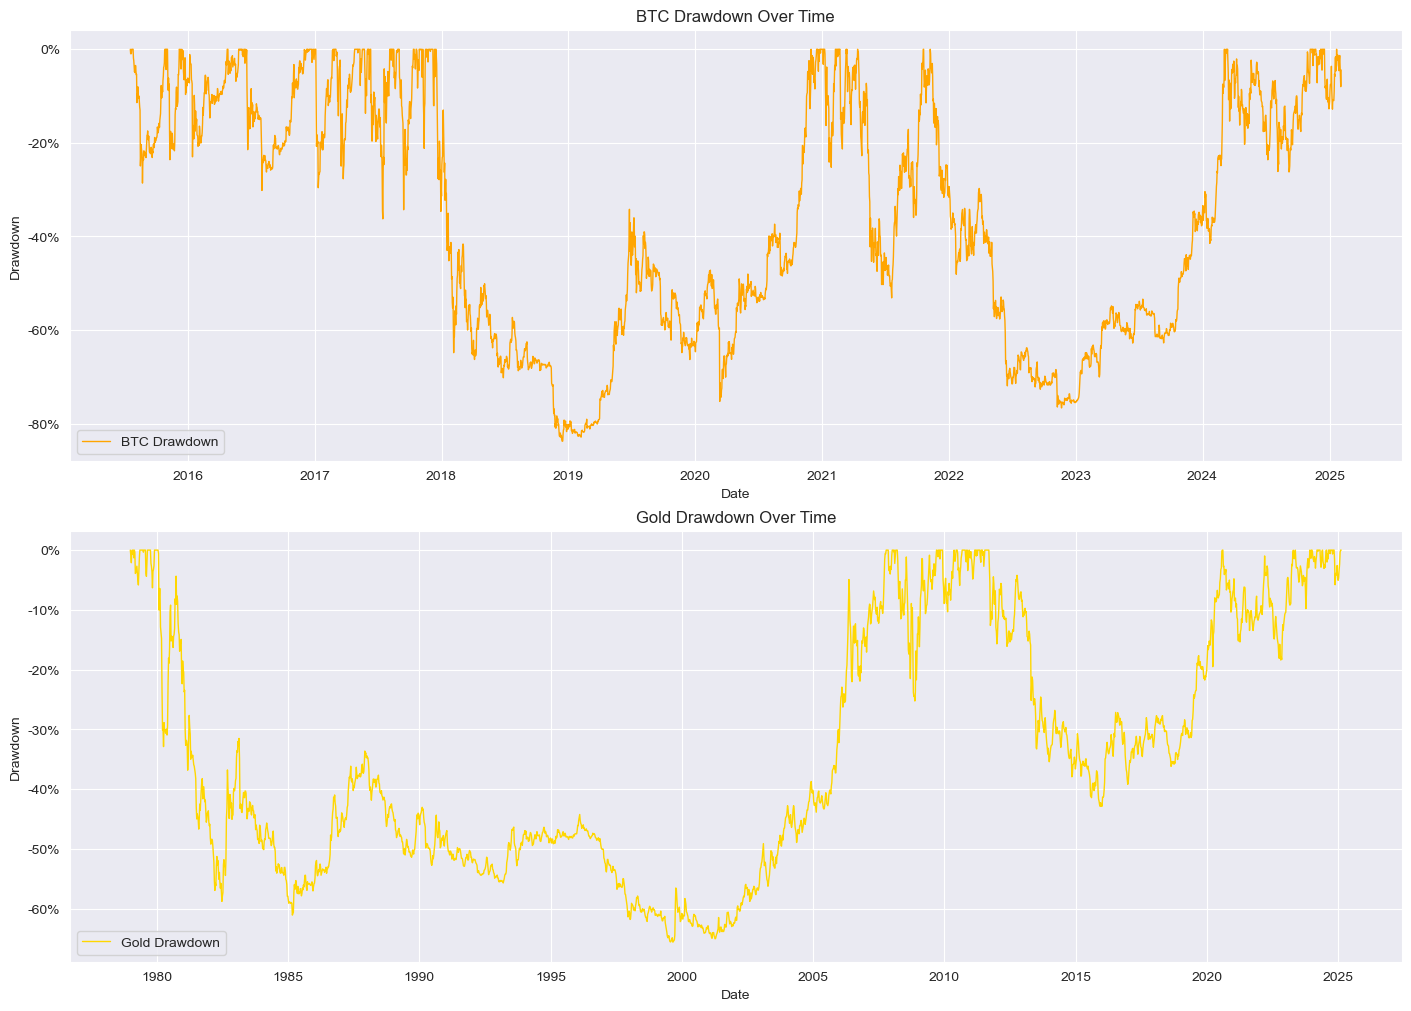

In [34]:
# Calculate drawdown for btc_data using BTCUSD
btc_data['Running_Max'] = btc_data['BTCUSD'].cummax()
btc_data['Drawdown'] = btc_data['BTCUSD'] / btc_data['Running_Max'] - 1

# Calculate drawdown for gold_data_weekly using XAUUSD
gold_data_weekly['Running_Max'] = gold_data_weekly['XAUUSD'].cummax()
gold_data_weekly['Drawdown'] = gold_data_weekly['XAUUSD'] / gold_data_weekly['Running_Max'] - 1

# Create a plot with 2 rows, one for each asset's drawdown
fig, axes = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

# Plot BTC drawdown
sns.lineplot(ax=axes[0], data=btc_data, x='Date', y='Drawdown', label='BTC Drawdown', color='orange', linewidth=1)
axes[0].set_title('BTC Drawdown Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Drawdown')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))  # Show percentage
axes[0].grid(visible=True)

# Plot Gold drawdown
sns.lineplot(ax=axes[1], data=gold_data_weekly, x='Date', y='Drawdown', label='Gold Drawdown', color='gold', linewidth=1)
axes[1].set_title('Gold Drawdown Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))  # Show percentage
axes[1].grid(visible=True)

# Show and save plot
if save_results:
    plt.savefig('./results/btc_and_gold_drawdowns.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

Without going into the entire history of Gold performance, let's look at its performance over key periods, and as a whole, with a keen focus on volatility and drawdowns:
- In the late 1970s, Gold's price rose sharply, driven by factors like high inflation, geopolitical tensions, and a lack of confidence in fiat currencies. Gold clearly upheld its store of value status during this time period, and while prices were very volatile, and comparable to all-time high volatility of the S&P 500, this is an example of good Volatility.
- After peaking around \$850 per ounce in January, 1980, Gold prices declined sharply in the early 1980's, largely due to increasing interest rates (the Federal Funds Rate peaked at over 20%) causing significant opportunity cost in holding non-yielding assets like Gold (compared to holding Government Bonds, for example). We notice that from 1980 to 1985 Gold's drawdown was 60%, i.e., it lost 60% of its value compared to the high recorded in 1980. This period was coupled with moderately high volatility, but clearly not good.
- In the period that ensued, until the late 2000's, volatility remained very low - bravo - but, unfortunately, the price did not touch its all-time for almost 30 years, until 2008, during the Global Financial Crisis (GFC). Happy, happy, low volatility.
- Gold performed really well during the GFC and years that followed, with the price rising from \$600 mid 2007, to \$1000 in March 2008. Thanks to Quantitative Easing, driving cheap borrowing, investors protected themselves against inflation fears by buying Gold, and the price rose to a high of $1,900 in September 2011. Low volatility was recorded throughout the period, a truly remarkable time for Gold, upholding its store of value status, and protecting against inflation fears.
- From 2012, we see significant drawdowns from the 2011 high, reaching 40% in 2015. It remained pretty stable thereafter until 2019, until the Covid pandemic when it reached a new all-time high of \$2,075, again protecting its store of value status against panic and uncertainty in global markets.

Indeed, we can see that, as research studies show (e.g. ...), Gold (largely) keeps its reputation as a safe haven during turbulent times. When we look at performance of a real basis, i.e., adjusting returns by inflation, Gold can perform poorly for long periods of time, e.g., 1980 to 2008.

We have significantly less data for Bitcoin, and given its emergent state, it is difficult, and prone to error, to perform a qualitative analysis of its performance, and thus to categorize its volatility as good or bad, for a given period of time. We can, however, see that:
- It is, on average, very volatile relative to other asset class.
- Its annual volatility has consistently been decreasing, quite substantially, from 2022 onwards.
- Its drawdowns are larger than that of Gold, but the time to recover from its troughs and to record new highs are substantially shorter.

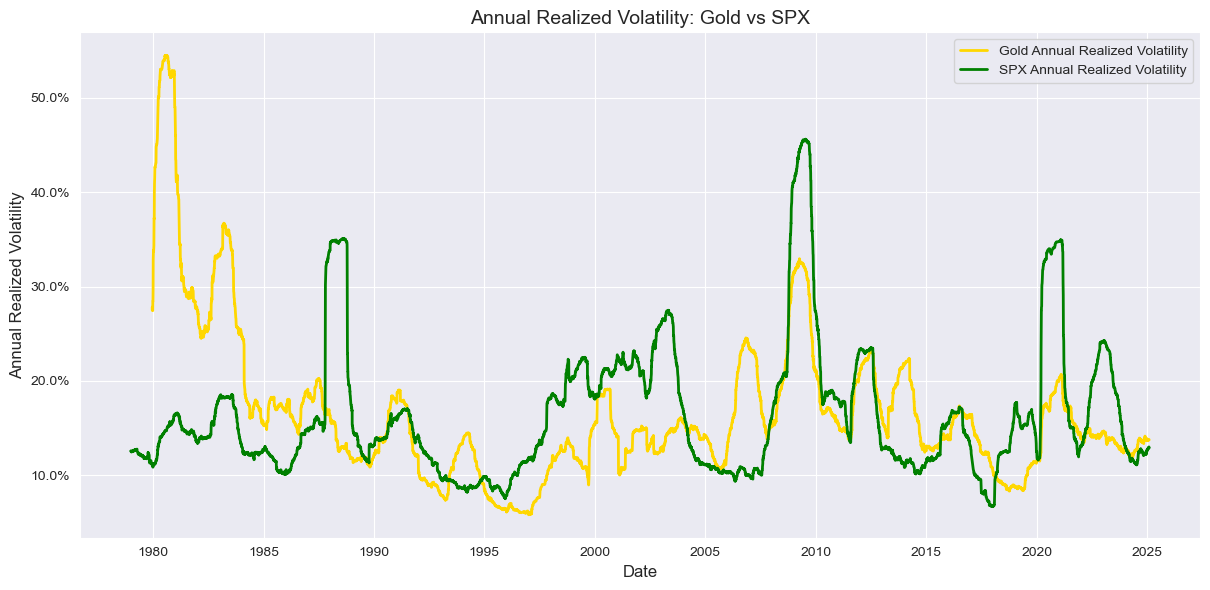

In [35]:
# Find the intersection of dates between gold_data and spx_data
merged = gold_data.merge(spx_data, on='Date', how='inner')

# Plot the annual realized volatility of gold_data and spx_data on the same chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged, x='Date', y='Annual_RV_x', label='Gold Annual Realized Volatility', color='gold', linewidth=2)
sns.lineplot(data=merged, x='Date', y='Annual_RV_y', label='SPX Annual Realized Volatility', color='green', linewidth=2)

# Improving the aesthetics
plt.title('Annual Realized Volatility: Gold vs SPX', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annual Realized Volatility', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))

# Show and save plot
if save_results:
    plt.savefig('./results/gold_and_spx_annual_vols.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

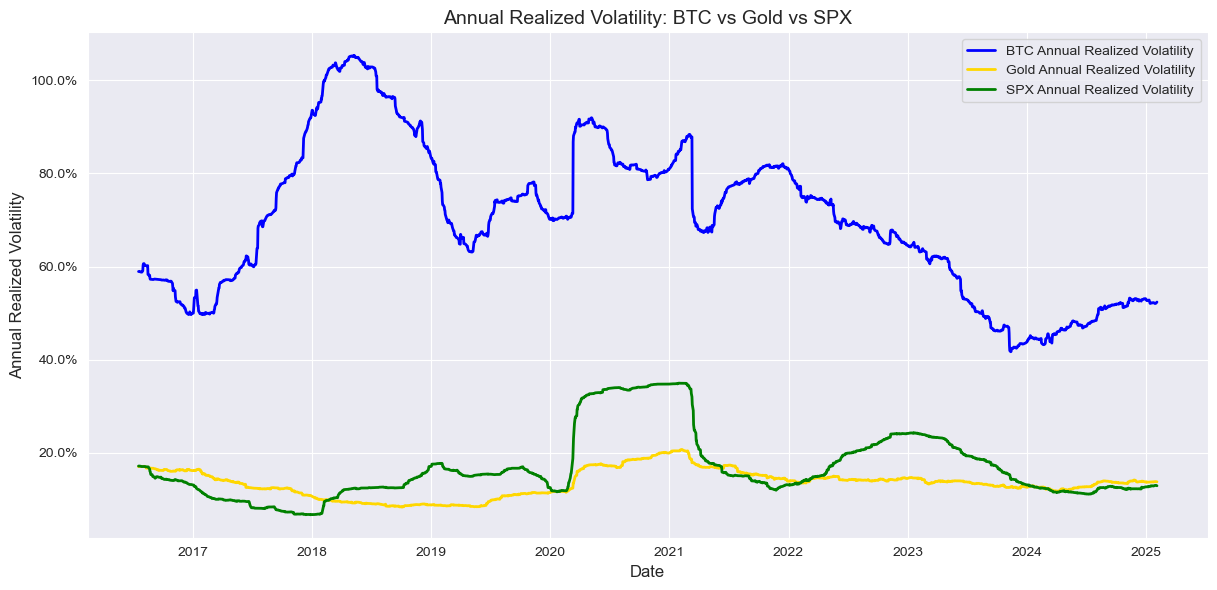

In [36]:
# Exclude rows where Annual_RV is NaN or 0 for any dataset
btc_data = btc_data[(btc_data['Annual_RV'].notna()) & (btc_data['Annual_RV'] != 0)]
gold_data = gold_data[(gold_data['Annual_RV'].notna()) & (gold_data['Annual_RV'] != 0)]
spx_data = spx_data[(spx_data['Annual_RV'].notna()) & (spx_data['Annual_RV'] != 0)]

# Find the intersection of dates between btc_data, gold_data, and spx_data
merged_vol = btc_data[['Date', 'Annual_RV']].merge(gold_data[['Date', 'Annual_RV']], on='Date', suffixes=('_BTC', '_Gold'))
merged_vol = merged_vol.merge(spx_data[['Date', 'Annual_RV']], on='Date')
merged_vol.rename(columns={'Annual_RV': 'Annual_RV_SPX'}, inplace=True)

# Plot the annualized realized volatility of BTC, Gold, and SPX on the same chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_vol, x='Date', y='Annual_RV_BTC', label='BTC Annual Realized Volatility', color='blue', linewidth=2)
sns.lineplot(data=merged_vol, x='Date', y='Annual_RV_Gold', label='Gold Annual Realized Volatility', color='gold', linewidth=2)
sns.lineplot(data=merged_vol, x='Date', y='Annual_RV_SPX', label='SPX Annual Realized Volatility', color='green', linewidth=2)

# Improving the aesthetics
plt.title('Annual Realized Volatility: BTC vs Gold vs SPX', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annual Realized Volatility', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))

# Show and save plot
if save_results:
    plt.savefig('./results/asset_vol_comparison.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

In [37]:
# Plot summary statistics for btc_data, gold_data, and spx_data in a single table

# Create a function to compute summary statistics
def compute_summary_stats(df, name):
    summary = {
        "Asset": name,
        "Mean Price": df[df.columns[1]].mean(),  # Mean of the price column
        "Max Price": df[df.columns[1]].max(),   # Maximum price
        "Min Price": df[df.columns[1]].min(),   # Minimum price
        "Mean Daily Return": df["Daily_Log_Return"].mean() * 100,  # Mean daily return in %
        "Volatility (Annual)": df["Annual_RV"].mean(),  # Mean annualized volatility
        "Volatility (Monthly)": df["Monthly_RV"].mean() # Mean monthly volatility
    }
    return summary

# Compute summary statistics for each dataset
btc_stats = compute_summary_stats(btc_data, "Bitcoin")
gold_stats = compute_summary_stats(gold_data, "Gold")
spx_stats = compute_summary_stats(spx_data, "SPX")

# Create a DataFrame to show the statistics in a single table
summary_table = pd.DataFrame([btc_stats, gold_stats, spx_stats])

# Customize column formats for better readability (e.g., rounding)
summary_table["Mean Price"] = summary_table["Mean Price"].round(2)
summary_table["Max Price"] = summary_table["Max Price"].round(2)
summary_table["Min Price"] = summary_table["Min Price"].round(2)
summary_table["Mean Daily Return"] = summary_table["Mean Daily Return"].round(4)
summary_table["Volatility (Annual)"] = summary_table["Volatility (Annual)"].round(4)
summary_table["Volatility (Monthly)"] = summary_table["Volatility (Monthly)"].round(4)

# Display the summary table
print(summary_table)

     Asset  Mean Price  Max Price  Min Price  Mean Daily Return  \
0  Bitcoin    24583.67  106159.26     537.47             0.1605   
1     Gold      805.44    2812.10     252.80             0.0152   
2      SPX      670.36    6118.71       4.40             0.0228   

   Volatility (Annual)  Volatility (Monthly)  
0               0.6997                0.6511  
1               0.1658                0.1554  
2               0.1669                0.1557  
